Install efficientnet for pytorch

In [1]:
!pip install efficientnet-pytorch

Import required libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
from tempfile import TemporaryDirectory
import pandas as pd
import shutil
import random
import torch.nn.functional as F
from torch.utils.data.sampler import WeightedRandomSampler
import time
from datetime import datetime
import datetime as dt
import copy
from efficientnet_pytorch import EfficientNet
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

# use best algorithm for hardware
cudnn.benchmark = True

# interactive mode for graph plot
plt.ion()

# set device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Extract data for use on google colab

In [ ]:
#copy data zip from drive
from google.colab import drive
drive.mount('/content/drive')
!cp drive/MyDrive/uni/Honours/ISIC_2019.zip ./data/ISIC_2019.zip

#unzip dataset
!unzip -x -q ./data/ISIC_2019.zip

#remove zip file
!rm ISIC_2019.zip

Mounted at /content/drive


Sort data into folders based on class

In [2]:
# function to sort the images into class folders based on given csv file
def copy_images_to_folders(csv_path, image_folder, output_folder):
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_path)

    # Iterate through each row in the DataFrame
    for index, row in df.iterrows():
        image_name = row['image'] + '.jpg'  # Assuming images have '.jpg' extension
        image_path = os.path.join(image_folder, image_name)

        # Iterate through class columns and copy images to the corresponding folders
        for class_name in df.columns[1:]:
            class_folder = os.path.join(output_folder, class_name)
            os.makedirs(class_folder, exist_ok=True)  # Create folder if it doesn't exist

            if row[class_name] == 1:  # Check if the image belongs to the class
                shutil.copy(image_path, class_folder)

csv_path = 'data/ISIC_2019_Training_GroundTruth.csv'
image_folder = 'data/ISIC_2019_Resized'
output_folder = 'data/ISIC_Sorted'

copy_images_to_folders(csv_path, image_folder, output_folder)

print("done")

done


Split data into training, validation and test

In [3]:
# declare variables for model creation
input_folder = 'data/ISIC_Sorted'  # This is the folder containing class subdirectories
output_folder = 'data/data_subset'  # The desired output folder for "training" and "validation" folders
#data_dir = '/content/data_subset'
sample_limit=None #None or a number up to 12875
train_ratio=0.6
val_ratio=0.2
test_ratio=0.2

print(train_ratio+val_ratio+test_ratio)

set_batch_size=64

#sample numbers by class copied here for reference
#MEL	NV	    BCC	    AK	 BKL	DF	VASC  SCC	UNK
#4522	12875	3323	867	 2624	239	253	  628	0

'''
Melanoma (MEL)
Melanocytic nevus (NV)
Basal cell carcinoma (BCC)
Actinic keratosis (AK)
Benign keratosis (BKL) [solar lentigo / seborrheic keratosis / lichen planus-like keratosis]
Dermatofibroma (DF)
Vascular lesion (VASC)
Squamous cell carcinoma (SCC)
None of the others (UNK)
'''

print("done")

1.0
done


In [4]:
# Remove existing "training" and "validation" folders if they exist
training_folder = os.path.join(output_folder, 'train')
validation_folder = os.path.join(output_folder, 'val')
test_folder = os.path.join(output_folder, 'test')

shutil.rmtree(training_folder, ignore_errors=True)
shutil.rmtree(validation_folder, ignore_errors=True)
shutil.rmtree(test_folder, ignore_errors=True)

# Create the "training" and "validation" folders
os.makedirs(training_folder, exist_ok=True)
os.makedirs(validation_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# generate list of class names from the folder structure
class_names = [class_name for class_name in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, class_name))]

print("done")

done


In [5]:
# Iterate through each class folder
for class_name in os.listdir(input_folder):
    class_folder_input = os.path.join(input_folder, class_name)
    if os.path.isdir(class_folder_input):
        # Get a list of all images in the class folder
        images = [img for img in os.listdir(class_folder_input) if img.endswith('.jpg')]
        
        # Limit the number of samples if sample_limit is provided
        if sample_limit is not None:
            images = images[:sample_limit]

        # Randomly shuffle the list of images
        np.random.seed(42)
        np.random.shuffle(images)

        # Calculate the number of samples for training and validation
        class_size = len(images)
        num_training_samples = int(class_size * train_ratio)
        num_val_samples = int(class_size * val_ratio)
        num_test_samples = int(class_size * test_ratio)

        # Create the class subfolders within the output folders
        class_folder_training = os.path.join(training_folder, class_name)
        class_folder_validation = os.path.join(validation_folder, class_name)
        class_folder_test = os.path.join(test_folder, class_name)
        os.makedirs(class_folder_training, exist_ok=True)
        os.makedirs(class_folder_validation, exist_ok=True)
        os.makedirs(class_folder_test, exist_ok=True)

        # Copy images to the training folder
        for image_name in images[:num_training_samples]:
            image_path = os.path.join(class_folder_input, image_name)
            shutil.copy(image_path, class_folder_training)
        # Copy images to the validation folder
        for image_name in images[num_training_samples:num_training_samples + num_val_samples]:
            image_path = os.path.join(class_folder_input, image_name)
            shutil.copy(image_path, class_folder_validation)
        # Copy images to the test folder
        for image_name in images[num_training_samples + num_val_samples:]:
            image_path = os.path.join(class_folder_input, image_name)
            shutil.copy(image_path, class_folder_test)

print("done")

done


In [6]:
#remove unknown folder as no samples
shutil.rmtree("data/data_subset/train/UNK", ignore_errors=True)
shutil.rmtree("data/data_subset/val/UNK", ignore_errors=True)
shutil.rmtree("data/data_subset/test/UNK", ignore_errors=True)

In [9]:
#transform data
data_transforms = {
'train': transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), shear=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
'val': transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
'test': transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
}

In [10]:
# create datasets and dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(output_folder, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=set_batch_size, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

#print checks to see if the values are the same - if yes then can remove the assignment here
class_names = image_datasets['train'].classes
print(f"file: ", class_names)

file:  ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']


In [11]:
def calculate_class_weights(data_dir):
    """
    Calculate class weights based on the number of samples in each class folder.
    
    Args:
    - data_dir (str): Path to the directory containing class folders.
    
    Returns:
    - class_weights (dict): Dictionary containing class weights.
    """
    # Initialize dictionary to store class samples counts
    class_samples = {}
    
    # Iterate over class folders
    for class_folder in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_folder)
        # Count the number of files (samples) in the class folder
        num_samples = len(os.listdir(class_path))
        # Store the count in the dictionary
        class_samples[class_folder] = num_samples
    
    # Calculate total number of samples
    total_samples = sum(class_samples.values())
    
    # Calculate class frequencies
    class_frequencies = {class_label: num_samples / total_samples for class_label, num_samples in class_samples.items()}
    
    # Compute inverse class frequencies as weights
    class_weights = {class_label: 1 / frequency for class_label, frequency in class_frequencies.items()}
    
    # Normalize the weights
    total_weight = sum(class_weights.values())
    class_weights_normalized = {class_label: weight / total_weight for class_label, weight in class_weights.items()}
    
    return class_weights_normalized

# Example usage:
data_dir = "data/data_subset/train"
class_weights = calculate_class_weights(data_dir)
print("Class Weights:", class_weights)


Class Weights: {'AK': 0.09696202173991755, 'BCC': 0.02529867100088165, 'BKL': 0.03203319650874023, 'DF': 0.3525891699633365, 'MEL': 0.01858468533164656, 'NV': 0.006526893372784094, 'SCC': 0.13409641304456682, 'VASC': 0.3339089490381266}


In [ ]:
# oversample training set

# get the sample size for each class
class_sizes = [len(os.listdir(os.path.join(training_folder, class_name))) for class_name in class_names]

# get the max sample size across classes
max_class_size = max(class_sizes)

# Calculate the desired repetitions for each class
# this is the number of times a sample needs to be repeated to match the max class size
desired_repetitions = [max_class_size // class_size if class_size > 0 else 1 for class_size in class_sizes]

# Iterate through each class and oversample accordingly
for class_index, class_name in enumerate(class_names):
    #get the training folder for the current class
    class_folder_training = os.path.join(training_folder, class_name)
    class_indices = [i for i, label in enumerate(image_datasets['train'].targets) if label == class_index]

    weights = [1.0 if label != class_index else desired_repetitions[class_index] for label in image_datasets['train'].targets]
    sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

    # Update the data loader for the "training" set with the weighted sampler
    dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'], batch_size=set_batch_size, sampler=sampler, num_workers=2)

show sample images

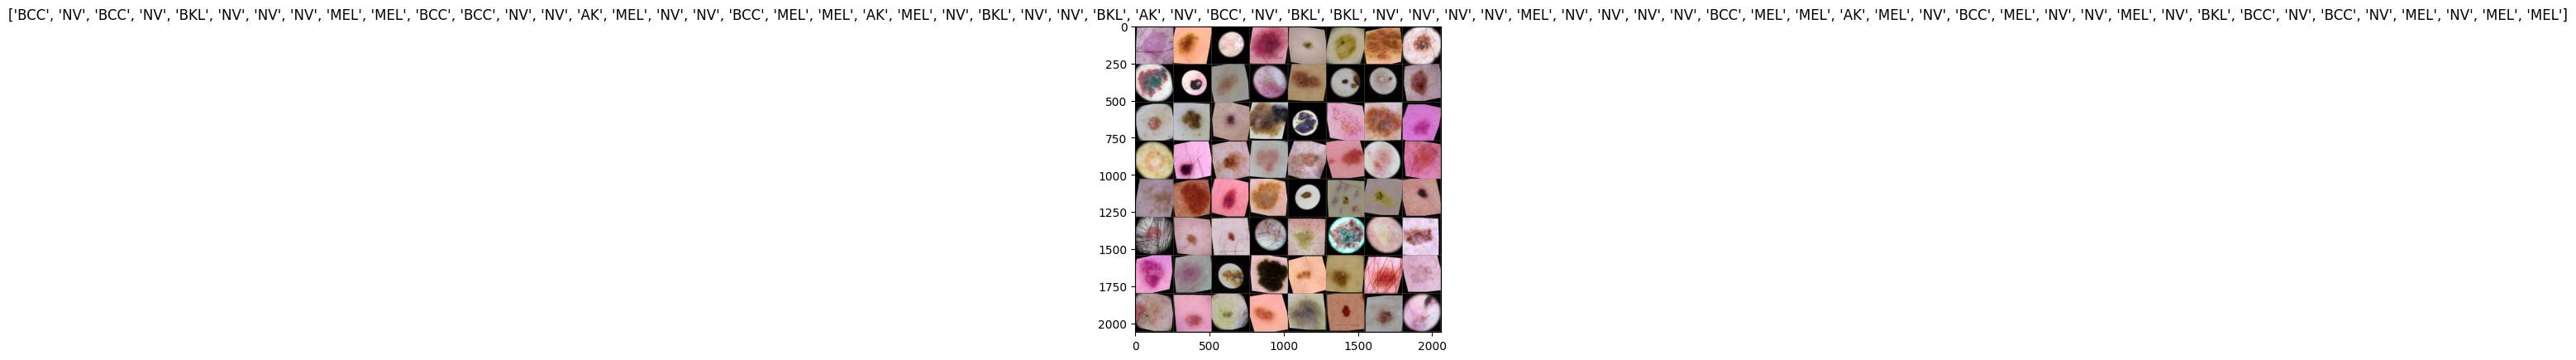

In [12]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

temporary fix for efficientnet weights issue

In [13]:
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

model fitting configuration

In [14]:
# Define a custom neural network model based on EfficientNetB0
class CustomEfficientNetB0(nn.Module):
    def __init__(self, num_classes=1, dropout_prob=0.3):
        super(CustomEfficientNetB0, self).__init__()
        # Load the pre-trained EfficientNetB0 model
        self.model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes)
        # Get the number of input features to the final fully connected layer
        num_ftrs = self.model._fc.in_features
        # Replace the final fully connected layer with an identity layer
        self.model._fc = nn.Identity()  # remove the original fully connected layer
        # Define additional fully connected layers
        self.fc1 = nn.Linear(num_ftrs, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = dropout_prob
    
    def forward(self, x, dropout=True):
        # Forward pass through the EfficientNetB0 model
        x = self.model(x)
        # Pass through the first fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))
        # Apply dropout regularization if specified
        if dropout:
            x = F.dropout(x, p=self.dropout)
        # Pass through the final fully connected layer
        x = self.fc2(x)
        return x

# Initialize the custom model with dropout
model_ft = CustomEfficientNetB0(num_classes=len(class_names), dropout_prob=0.3)

# Move the model to the specified device (e.g., GPU or CPU)
model_ft = model_ft.to(device)

# Define the loss function (cross-entropy loss)
#criterion = nn.CrossEntropyLoss()

# Define the loss function with class weights (cross-entropy loss)
class_weights_tensor = torch.tensor(list(class_weights.values()), dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Use the Adam optimizer for training
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Define a learning rate scheduler to decay the learning rate
# by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Loaded pretrained weights for efficientnet-b0


In [15]:
class FocalLossMultiClass(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduction='mean'):
        super(FocalLossMultiClass, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

# Replacing the loss function definition with Focal Loss for multi-class classification
criterion = FocalLossMultiClass()

In [16]:
def validate_model(model, criterion, data_loader, device, num_val_mc_samples=10):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs_list = [model(inputs).unsqueeze(0) for _ in range(num_val_mc_samples)]
            outputs_mean = torch.cat(outputs_list, dim=0).mean(dim=0)
            loss = criterion(outputs_mean, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs_mean, 1)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += labels.size(0)
    
    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = running_corrects.double() / len(data_loader.dataset)
    return epoch_loss, epoch_acc

In [17]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device, num_epochs=50, num_val_mc_samples=10, loss_weight=0.5):
    since = time.time()
    best_combined_metric = 0.0
    best_model_weights = copy.deepcopy(model.state_dict())
    best_val_loss = 0.0
    best_val_acc = 0.0
    best_epoch = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        for epoch in range(num_epochs):
            current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            print(f'Epoch {epoch + 1}/{num_epochs} - {current_time}')
            print('-' * 10)

            for phase in ['train', 'val']:
                model.train(phase == 'train')
                data_loader = dataloaders[phase]

                if phase == 'train':
                    running_loss = 0.0
                    running_corrects = 0
                    total_samples = 0
                    
                    for inputs, labels in data_loader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        optimizer.zero_grad()
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()

                        running_loss += loss.item() * inputs.size(0)
                        _, preds = torch.max(outputs, 1)
                        running_corrects += torch.sum(preds == labels.data)
                        total_samples += labels.size(0)

                    epoch_loss = running_loss / dataset_sizes[phase]
                    epoch_acc = running_corrects.double() / total_samples
                    print(f'{phase.capitalize()} Loss: {epoch_loss:.4f}, {phase.capitalize()} Acc: {epoch_acc:.4f}')
                    
                    if phase == 'train':
                        train_losses.append(epoch_loss)
                        train_accuracies.append(epoch_acc)
                    
                else:
                    epoch_loss, epoch_acc = validate_model(model, criterion, data_loader, device, num_val_mc_samples)
                    val_losses.append(epoch_loss)
                    val_accuracies.append(epoch_acc)
                    print(f'{phase.capitalize()} Loss: {epoch_loss:.4f}, {phase.capitalize()} Acc: {epoch_acc:.4f}')
                    
                    # Calculate combined metric
                    combined_metric = epoch_acc - loss_weight * epoch_loss
                    if combined_metric > best_combined_metric:
                        best_combined_metric = combined_metric
                        best_val_loss = epoch_loss
                        best_val_acc = epoch_acc
                        best_epoch = epoch + 1  # Store the epoch number
                        torch.save(model.state_dict(), best_model_params_path)

            print()

        print(f'Best combined metric: {best_combined_metric:.4f}')
        print(f'Loss associated with the best combined metric: {best_val_loss:.4f}')
        print(f'Accuracy associated with the best combined metric: {best_val_acc:.4f}')
        print(f'Epoch associated with the best model: {best_epoch}')
        model.load_state_dict(torch.load(best_model_params_path))
    
    return model, train_losses, train_accuracies, val_losses, val_accuracies, best_epoch

model_ft, train_losses, train_accuracies, val_losses, val_accuracies, best_epoch = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes, device, num_epochs=50, num_val_mc_samples=100, loss_weight=0.5)

Epoch 1/50 - 2024-03-04 08:01:10
----------
Train Loss: 0.6108, Train Acc: 0.6405
Val Loss: 0.5793, Val Acc: 0.6600

Epoch 2/50 - 2024-03-04 08:21:44
----------
Train Loss: 0.4717, Train Acc: 0.6902
Val Loss: 0.4279, Val Acc: 0.7025

Epoch 3/50 - 2024-03-04 08:38:41
----------
Train Loss: 0.4281, Train Acc: 0.7064
Val Loss: 0.4106, Val Acc: 0.7137

Epoch 4/50 - 2024-03-04 08:55:37
----------
Train Loss: 0.3869, Train Acc: 0.7219
Val Loss: 0.3989, Val Acc: 0.7197

Epoch 5/50 - 2024-03-04 09:12:34
----------
Train Loss: 0.3576, Train Acc: 0.7394
Val Loss: 0.3867, Val Acc: 0.7120

Epoch 6/50 - 2024-03-04 09:29:31
----------
Train Loss: 0.3299, Train Acc: 0.7486
Val Loss: 0.3857, Val Acc: 0.7292

Epoch 7/50 - 2024-03-04 09:46:27
----------
Train Loss: 0.3043, Train Acc: 0.7607
Val Loss: 0.3921, Val Acc: 0.7461

Epoch 8/50 - 2024-03-04 10:03:23
----------
Train Loss: 0.2791, Train Acc: 0.7765
Val Loss: 0.3799, Val Acc: 0.7418

Epoch 9/50 - 2024-03-04 10:20:20
----------
Train Loss: 0.2609, 

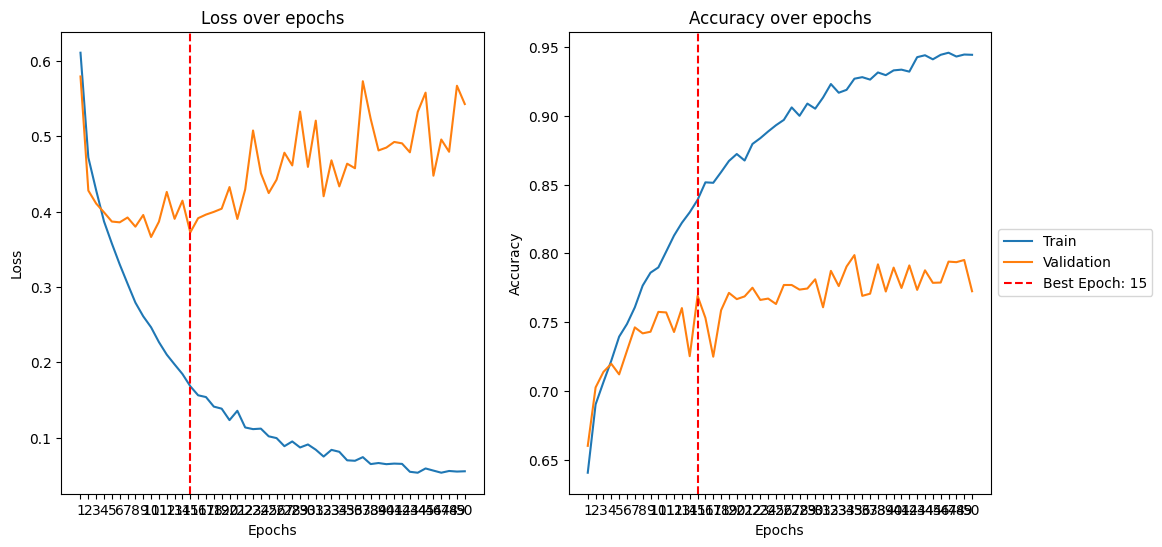

In [18]:
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, best_epoch):
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Move accuracies to CPU
    # not needed for losses as they were never moved to GPU
    train_accuracies = [acc.cpu().numpy() for acc in train_accuracies]
    val_accuracies = [acc.cpu().numpy() for acc in val_accuracies]

    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(1, len(train_losses)+1), train_losses, label='Train')
    plt.plot(np.arange(1, len(val_losses)+1), val_losses, label='Validation')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Epoch')  # Add vertical line at best_epoch
    plt.legend().remove()  # Remove legend from the first subplot
    plt.xticks(np.arange(1, len(train_losses)+1))  # Set x-axis ticks from 1 to the number of epochs

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(1, len(train_accuracies)+1), train_accuracies, label='Train')
    plt.plot(np.arange(1, len(val_accuracies)+1), val_accuracies, label='Validation')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Add the best epoch to the legend for the second subplot
    handles, labels = plt.gca().get_legend_handles_labels()
    best_epoch_label = f'Best Epoch: {best_epoch}'
    handles.append(plt.Line2D([], [], color='r', linestyle='--', label=best_epoch_label))
    plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks(np.arange(1, len(train_accuracies)+1))  # Set x-axis ticks from 1 to the number of epochs

    plt.axvline(x=best_epoch, color='r', linestyle='--')  # Add vertical line at best_epoch

    plt.show()

plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, best_epoch)


In [32]:
# Save the trained model
torch.save(model_ft.state_dict(), 'data/trained_model_big.pth')

In [13]:
#load the saved model
model_ft.load_state_dict(torch.load('data/trained_model_big.pth'))
#model.eval()  # Set the model to evaluation mode if needed

<All keys matched successfully>

visualise trained model

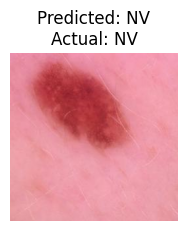

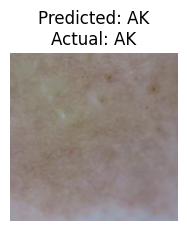

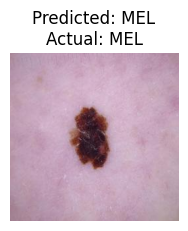

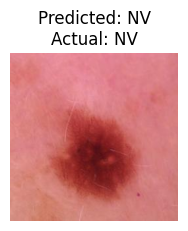

In [19]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')

                predicted_class = class_names[preds[j]]
                actual_class = class_names[labels[j]]
                title = f'Predicted: {predicted_class}\nActual: {actual_class}'
                ax.set_title(title)

                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model_ft, num_images=4)

In [20]:
# Lists to store results
risks_list = []
labels_list = []
print("done")

done


In [21]:
# get a list of risks associated with the removal of the least certain samples
def calculate_risks(guesses_are_correct, uncertainties):
    # create a blank list
    risks = []

    # while uncertainties isn't empty
    while uncertainties:
        # get risk based on average correctness/accuracy
        risk = 1 - (sum(guesses_are_correct) / len(guesses_are_correct))
        # append to list
        risks.append(risk)

        # remove results for the least certain sample
        max_uncertainty_index = uncertainties.index(max(uncertainties))
        uncertainties.pop(max_uncertainty_index)
        guesses_are_correct.pop(max_uncertainty_index)

    risks.reverse()

    return risks

print("done")

done


In [22]:
def calculate_softmax_uncertainties(model, dataloader, class_names, device):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []

    with torch.no_grad():
        # for every batch in the dataloader
        for inputs, labels in dataloader:
            #get the inputs and labels
            inputs = inputs.to(device)
            labels = labels.to(device)

            # get the outputs
            outputs = model(inputs, dropout=False)
            # get the softmax outputs
            probabilities = F.softmax(outputs, dim=1)
            # get the class predictions
            _, predicted = torch.max(outputs, 1)
            # check and store whether predictions are correct
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

            # Compute uncertainty based on softmax probabilities
            for idx in range(len(predicted)):
                predicted_class = predicted[idx].item()
                uncertainty = 1.0 - probabilities[idx, predicted_class].item()  # Using confidence as uncertainty
                uncertainties.append(uncertainty)

    return guesses_are_correct, uncertainties

risks_list.append(calculate_risks(*calculate_softmax_uncertainties(model_ft, dataloaders['test'], class_names, device)))
labels_list.append("Softmax Response")
print("done")

done


In [23]:
def calculate_random_uncertainties(model, dataloader, class_names, device):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs, dropout=False)
            _, predicted = torch.max(outputs, 1)
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

            # Generate a single random uncertainty value for each predicted class
            for idx in range(len(predicted)):
                uncertainty = random.random()
                uncertainties.append(uncertainty)

    return guesses_are_correct, uncertainties

risks_list.append(calculate_risks(*calculate_random_uncertainties(model_ft, dataloaders['test'], class_names, device)))
labels_list.append("Random Uncertainties")
print("done")

done


In [24]:
def calculate_mc_dropout_uncertainties_by_sample(model, dataloader, class_names, device, num_samples=100):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []

    with torch.no_grad():  # No need to compute gradients during evaluation
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            mean_predictions = torch.zeros(num_samples, inputs.size(0), len(class_names)).to(device)

            # Generate predictions with dropout for multiple samples
            for i in range(num_samples):
                outputs = model(inputs)
                predictions = F.softmax(outputs, dim=1)
                mean_predictions[i] = predictions

            # Calculate mean prediction across samples
            mean_prediction = torch.mean(mean_predictions, dim=0)

            # Calculate uncertainty using mean prediction
            uncertainties.extend(1.0 - torch.max(mean_prediction, dim=1)[0].cpu().numpy())

            # Determine correctness of predictions
            _, predicted = torch.max(mean_prediction, 1)
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

            # Print date/time for monitoring
            print(f"{dt.datetime.now()} - Batch {batch_idx + 1}/{len(dataloader)} processed")

    return guesses_are_correct, uncertainties

risks_list.append(calculate_risks(*calculate_mc_dropout_uncertainties_by_sample(model_ft, dataloaders['test'], class_names, device)))
labels_list.append("MCD By Sample")

2024-03-05 00:11:12.072575 - Batch 1/80 processed
2024-03-05 00:11:23.349050 - Batch 2/80 processed
2024-03-05 00:11:34.638664 - Batch 3/80 processed
2024-03-05 00:11:45.948180 - Batch 4/80 processed
2024-03-05 00:11:57.244253 - Batch 5/80 processed
2024-03-05 00:12:08.537426 - Batch 6/80 processed
2024-03-05 00:12:19.846251 - Batch 7/80 processed
2024-03-05 00:12:31.134167 - Batch 8/80 processed
2024-03-05 00:12:42.416687 - Batch 9/80 processed
2024-03-05 00:12:53.711902 - Batch 10/80 processed
2024-03-05 00:13:05.231827 - Batch 11/80 processed
2024-03-05 00:13:16.631261 - Batch 12/80 processed
2024-03-05 00:13:27.936481 - Batch 13/80 processed
2024-03-05 00:13:39.238360 - Batch 14/80 processed
2024-03-05 00:13:50.606025 - Batch 15/80 processed
2024-03-05 00:14:01.933029 - Batch 16/80 processed
2024-03-05 00:14:13.235157 - Batch 17/80 processed
2024-03-05 00:14:24.524249 - Batch 18/80 processed
2024-03-05 00:14:35.814339 - Batch 19/80 processed
2024-03-05 00:14:47.096908 - Batch 20/80

In [25]:
def calculate_mc_dropout_uncertainties_by_class(model, dataloader, class_names, device, num_samples=100):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []

    with torch.no_grad():  # No need to compute gradients during evaluation
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            logits_list = []  # Initialize a list to store logits for each sample

            # Generate predictions with dropout for multiple samples
            for i in range(num_samples):
                outputs = model(inputs)
                logits_list.append(outputs)  # Store logits for each sample

            # Concatenate logits along a new dimension to create a tensor
            logits_tensor = torch.stack(logits_list, dim=0)

            # Calculate average output across all samples for each class
            class_avg_outputs = torch.mean(logits_tensor, dim=0)

            # Make prediction based on class with highest average output
            _, predicted = torch.max(class_avg_outputs, 1)

            # Calculate uncertainty using the highest average output
            uncertainties.extend(1.0 - torch.max(class_avg_outputs, dim=1)[0].cpu().numpy())

            # Determine correctness of predictions
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

            # Print date/time for monitoring
            print(f"{dt.datetime.now()} - Batch {batch_idx + 1}/{len(dataloader)} processed")

    return guesses_are_correct, uncertainties

risks_list.append(calculate_risks(*calculate_mc_dropout_uncertainties_by_class(model_ft, dataloaders['test'], class_names, device)))
labels_list.append("MCD By Class")

2024-03-05 00:26:14.673018 - Batch 1/80 processed
2024-03-05 00:26:25.960598 - Batch 2/80 processed
2024-03-05 00:26:37.255809 - Batch 3/80 processed
2024-03-05 00:26:48.538107 - Batch 4/80 processed
2024-03-05 00:26:59.821910 - Batch 5/80 processed
2024-03-05 00:27:11.104546 - Batch 6/80 processed
2024-03-05 00:27:22.383703 - Batch 7/80 processed
2024-03-05 00:27:33.676570 - Batch 8/80 processed
2024-03-05 00:27:44.982684 - Batch 9/80 processed
2024-03-05 00:27:56.516562 - Batch 10/80 processed
2024-03-05 00:28:07.817098 - Batch 11/80 processed
2024-03-05 00:28:19.095608 - Batch 12/80 processed
2024-03-05 00:28:30.382151 - Batch 13/80 processed
2024-03-05 00:28:41.674702 - Batch 14/80 processed
2024-03-05 00:28:52.961716 - Batch 15/80 processed
2024-03-05 00:29:04.242093 - Batch 16/80 processed
2024-03-05 00:29:15.519989 - Batch 17/80 processed
2024-03-05 00:29:26.795846 - Batch 18/80 processed
2024-03-05 00:29:38.079879 - Batch 19/80 processed
2024-03-05 00:29:49.364622 - Batch 20/80

In [26]:
def calculate_variance_uncertainties(model, dataloader, class_names, device):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []

    with torch.no_grad():
        # for every batch in the dataloader
        for inputs, labels in dataloader:
            # get the inputs and labels
            inputs = inputs.to(device)
            labels = labels.to(device)

            # get the outputs
            outputs = model(inputs, dropout=False)
            # get the softmax outputs
            probabilities = F.softmax(outputs, dim=1)
            # get the class predictions
            _, predicted = torch.max(outputs, 1)
            # check and store whether predictions are correct
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

            # Compute uncertainty based on variance over classes
            variance = torch.var(probabilities, dim=1)
            uncertainties.extend(-variance.cpu().numpy())

    return guesses_are_correct, uncertainties

risks_list.append(calculate_risks(*calculate_variance_uncertainties(model_ft, dataloaders['test'], class_names, device)))
labels_list.append("Variance over Classes")
print("done")

done


In [27]:
def calculate_entropy_uncertainties(model, dataloader, class_names, device):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []

    with torch.no_grad():
        # for every batch in the dataloader
        for inputs, labels in dataloader:
            # get the inputs and labels
            inputs = inputs.to(device)
            labels = labels.to(device)

            # get the outputs
            outputs = model(inputs, dropout=True)
            # get the softmax outputs
            probabilities = F.softmax(outputs, dim=1)
            # get the class predictions
            _, predicted = torch.max(outputs, 1)
            # check and store whether predictions are correct
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

            # Compute uncertainty based on predictive entropy
            entropy = -torch.sum(probabilities * torch.log(probabilities + 1e-10), dim=1)  # Adding a small value to avoid log(0)
            uncertainties.extend(entropy.cpu().numpy())

    return guesses_are_correct, uncertainties

risks_list.append(calculate_risks(*calculate_entropy_uncertainties(model_ft, dataloaders['test'], class_names, device)))
labels_list.append("Predictive Entropy")
print("done")

done


In [28]:
def calculate_mutual_information_uncertainties(model, dataloader, class_names, device):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []

    with torch.no_grad():
        # for every batch in the dataloader
        for inputs, labels in dataloader:
            # get the inputs and labels
            inputs = inputs.to(device)
            labels = labels.to(device)

            # get the outputs
            outputs = model(inputs, dropout=True)
            # get the softmax outputs
            probabilities = F.softmax(outputs, dim=1)
            # get the class predictions
            _, predicted = torch.max(outputs, 1)
            # check and store whether predictions are correct
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

            # Compute uncertainty based on mutual information
            uniform_distribution = torch.full_like(probabilities, 1.0 / probabilities.size(1))
            mutual_information = F.kl_div(probabilities.log(), uniform_distribution, reduction='none').sum(dim=1)
            uncertainties.extend(-mutual_information.cpu().numpy())

    return guesses_are_correct, uncertainties

risks_list.append(calculate_risks(*calculate_mutual_information_uncertainties(model_ft, dataloaders['test'], class_names, device)))
labels_list.append("Mutual Information")
print("done")

done


In [29]:
# Interpolate the data for smoother curves
x_values = np.arange(len(risks_list[0]))
total_steps = len(x_values)

# Convert x-values to percentage
x_smooth_percentage = (x_values / total_steps)  # Already between 0 and 1

# Create a smooth range for the x-axis
x_smooth_percentage_interp = np.linspace(x_smooth_percentage.min(), x_smooth_percentage.max(), 300)

In [30]:
def calculate_aurc(risks_list, labels_list, x_smooth_percentage_interp, x_smooth_percentage):
    aucr_cutoff_list = []  # For 20% cutoff
    aucr_full_list = []    # For the entire curve
    
    for risks, label in zip(risks_list, labels_list):
        risks_smooth = np.interp(x_smooth_percentage_interp, x_smooth_percentage, risks)
        
        # Find indices corresponding to values less than or equal to 20% coverage
        cutoff_index = np.argmax(x_smooth_percentage_interp >= 0.2)  # 20% coverage in normalized scale

        # Calculate area under the curve from 100% coverage to the 20% cutoff
        area_cutoff = np.trapz(risks_smooth[cutoff_index:], x=x_smooth_percentage_interp[cutoff_index:])
        aucr_cutoff_list.append((label, area_cutoff))

        # Calculate area under the entire curve
        area_full = np.trapz(risks_smooth, x=x_smooth_percentage_interp)
        aucr_full_list.append((label, area_full))

    # Sort the lists based on AURC values
    aucr_cutoff_list.sort(key=lambda x: x[1])  # Sorting based on AURC for 20% cutoff
    aucr_full_list.sort(key=lambda x: x[1])    # Sorting based on AURC for the entire curve
    
    return aucr_cutoff_list, aucr_full_list

# Call the calculate_aurc function to compute AURC values
aucr_cutoff_list, aucr_full_list = calculate_aurc(risks_list, labels_list, x_smooth_percentage_interp, x_smooth_percentage)

# Print the AURC values
max_label_length = max(len(item[0]) for item in aucr_cutoff_list + aucr_full_list)
print("Label" + " " * (max_label_length - 5) + "\tAURC (20% cutoff)")
print("-" * (max_label_length + 15))
for item in aucr_cutoff_list:
    print(f"{item[0]}" + " " * (max_label_length - len(item[0]) + 5) + f"\t{item[1]:.4f}")

print("\nLabel" + " " * (max_label_length - 5) + "\tAURC (full)")
print("-" * (max_label_length + 15))
for item in aucr_full_list:
    print(f"{item[0]}" + " " * (max_label_length - len(item[0]) + 5) + f"\t{item[1]:.4f}")

Label                	AURC (20% cutoff)
------------------------------------
MCD By Sample             	0.0878
Softmax Response          	0.0880
Variance over Classes     	0.0881
Predictive Entropy        	0.0923
MCD By Class              	0.1142
Mutual Information        	0.1282
Random Uncertainties      	0.1828

Label                	AURC (full)
------------------------------------
MCD By Sample             	0.0906
Softmax Response          	0.0910
Variance over Classes     	0.0910
Predictive Entropy        	0.0947
MCD By Class              	0.1255
Mutual Information        	0.1456
Random Uncertainties      	0.2300


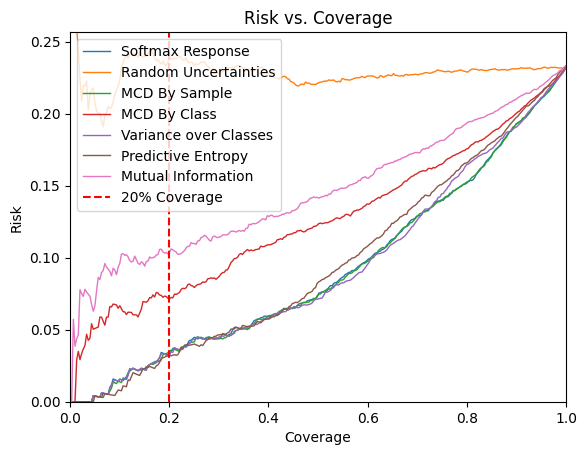

done


In [31]:
def plot_risk_coverage(risks_list, labels_list, x_smooth_percentage_interp, x_smooth_percentage):
    max_risk_100_coverage = 0  # Initialize max risk value at 100% coverage

    for risks, label in zip(risks_list, labels_list):
        risks_smooth = np.interp(x_smooth_percentage_interp, x_smooth_percentage, risks)
        plt.plot(x_smooth_percentage_interp, risks_smooth, label=label, linewidth=1)
        
        # Update max risk value at 100% coverage if necessary
        max_risk_100_coverage = max(max_risk_100_coverage, risks_smooth[-1])

    # x-axis label with a percentage
    plt.xlabel('Coverage')
    plt.ylabel('Risk')
    plt.title('Risk vs. Coverage')

    # Add a vertical line at approximately 20% coverage
    plt.axvline(x=0.2, color='red', linestyle='--', label='20% Coverage')

    # Adjust the x-axis limits to range from 0 to 1
    plt.xlim(0, 1)

    # Adjust the y-axis limits
    plt.ylim(0, max_risk_100_coverage * 1.1)  # Set the upper limit slightly higher than the maximum risk at 100% coverage

    # Show legend
    plt.legend()

    plt.show()

# Plot the risk coverage curve
plot_risk_coverage(risks_list, labels_list, x_smooth_percentage_interp, x_smooth_percentage)
print("done")